Pengumpulan Data

In [1]:
import pandas as pd

# Membaca data dari file Excel
df = pd.read_excel("data-tinggi-muka-air-di-provinsi-dki-jakarta-tahun-2020-(1759198584525).xlsx")

# Menampilkan 5 data pertama
df.head()


,nama_pintu_air,lokasi,latitude,longitude,tanggal,tinggi_air,status_siaga,periode_data
0,P.A. Ancol Flusing,Ciliwung,-6.129.859,106.831.254,31/12/2019 23:40,1700,Status : Normal,202001
1,P.A. Hek,Kali Baru Timur,-6.287.305,106.870.630,31/12/2019 12:20,1710,Status : Siaga 3,202001
2,PA. Cibalok - Gadog,Ciliwung,-6.653.417,106.869.551,23/12/2019 03:50,180,Status : Normal,202001
3,PS. Katulampa (Hulu),Ciliwung,-6.633.167,106.836.806,01/01/2020 00:10,470,Status : Normal,202001
4,PS. Depok,Ciliwung,-6.400.514.000,106.832.143.000,01/01/2020 00:10,1670,Status : Normal,202001


Prapemrosesan Data

In [2]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Mengubah tipe data waktu
df['tanggal'] = pd.to_datetime(df['tanggal'])
df = df.sort_values('tanggal')

# Mengisi nilai kosong
df['tinggi_air'] = df['tinggi_air'].interpolate()

# Hilangkan duplikat dan outlier
q1, q3 = df['tinggi_air'].quantile([0.05, 0.95])
df = df[(df['tinggi_air'] >= q1) & (df['tinggi_air'] <= q3)]

# Normalisasi data
scaler = MinMaxScaler()
df['tinggi_air'] = scaler.fit_transform(df[['tinggi_air']])


/tmp/ipython-input-655186821.py:5: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['tanggal'] = pd.to_datetime(df['tanggal'])


In [3]:
# Menampilkan 5 data pertama
df.head()

,nama_pintu_air,lokasi,latitude,longitude,tanggal,tinggi_air,status_siaga,periode_data
2,PA. Cibalok - Gadog,Ciliwung,-6.653.417,106.869.551,2019-12-23 03:50:00,0.099800,Status : Normal,202001
23,PA. Cibalok - Gadog,Ciliwung,-6.653.417,106.869.551,2019-12-23 03:50:00,0.099800,Status : Normal,202001
514,PA. Cibalok - Gadog,Ciliwung,-6.653.417,106.869.551,2019-12-23 03:50:00,0.099800,Status : Normal,202001
1,P.A. Hek,Kali Baru Timur,-6.287.305,106.870.630,2019-12-31 12:20:00,0.405190,Status : Siaga 3,202001
527,PA. Pulo Gadung,Sunter,-6.191,106.904.194,2019-12-31 16:50:00,0.750499,Status : Normal,202001


Pembuatan Fitur

In [4]:
# Membuat fitur lag
df['lag_1'] = df['tinggi_air'].shift(1)
df['lag_2'] = df['tinggi_air'].shift(2)
df['lag_3'] = df['tinggi_air'].shift(3)

#Drop NA
df = df.dropna()


Model Random Forest

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Pembagian data
X = df[['lag_1', 'lag_2', 'lag_3']]
y = df['tinggi_air']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Melatih model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)


Model ARIMA

In [30]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Asumsi: data sudah dibaca dan dibersihkan
# df memiliki index tanggal dan kolom 'tinggi_air'
# Contoh:
# df = data[['tanggal', 'tinggi_air']].copy()
# df['tanggal'] = pd.to_datetime(df['tanggal'])
# df.set_index('tanggal', inplace=True)
# df = df.sort_index()

# Split data menjadi train dan test
split = int(len(df) * 0.8)
train, test = df['tinggi_air'][:split], df['tinggi_air'][split:]

# --- Model ARIMA (3,1,2) ---
model = ARIMA(train, order=(3,1,2))
model_fit = model.fit()

# Ringkasan hasil model
print(model_fit.summary())

# Prediksi ke depan sepanjang data test
forecast = model_fit.forecast(steps=len(test))
forecast = pd.Series(forecast, index=test.index)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             tinggi_air   No. Observations:               339708
Model:                 ARIMA(3, 1, 2)   Log Likelihood               94897.840
Date:                Sun, 05 Oct 2025   AIC                        -189783.679
Time:                        14:30:13   BIC                        -189719.264
Sample:                             0   HQIC                       -189765.146
                             - 339708                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8199      0.066    -12.398      0.000      -0.950      -0.690
ar.L2          0.0403      0.004      9.692      0.000       0.032       0.048
ar.L3         -0.0089      0.002     -5.011      0.0

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Evaluasi Model

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest → MAE={mae_rf:.4f}, RMSE={rmse_rf:.4f}, R²={r2_rf:.4f}")

Random Forest → MAE=0.1424, RMSE=0.1820, R²=-0.1268


visualisai dan interprestasi

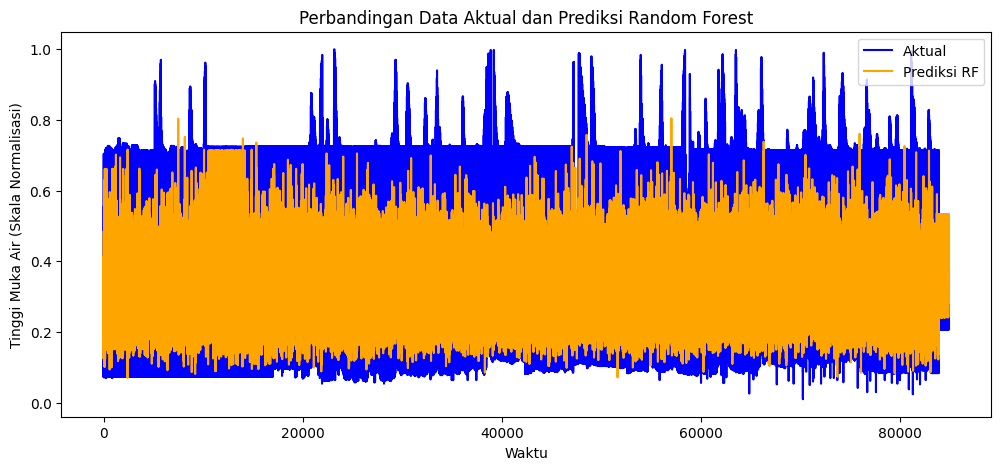

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test.values, label='Aktual', color='blue')
plt.plot(y_pred_rf, label='Prediksi RF', color='orange')
plt.title('Perbandingan Data Aktual dan Prediksi Random Forest')
plt.xlabel('Waktu')
plt.ylabel('Tinggi Muka Air (Skala Normalisasi)')
plt.legend()
plt.show()